Already get rid of TFflags, set branch to 1 and also being able to do regression without b 
1. get rid of branches
2. replace OT_solver with sinkhorn solver
 

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import multiprocessing
from functools import partial
import warnings
import ot
import h5py

### OT Solver 

In [4]:
def OTsolver_MATLABCODE(mu0, mu1, C, epsilon, uInit=None):
        """
        Optimal Transport solver using Sinkhorn algorithm with entropic regularization.

        Parameters:
        -----------
        mu0 : array_like
            Source distribution (will be reshaped to column vector)
        mu1 : array_like
            Target distribution (will be reshaped to column vector)
        C : array_like
            Cost matrix
        epsilon : float
            Regularization parameter
        uInit : array_like, optional
            Initial value for dual variable u1

        Returns:
        --------
        transport_cost : float
            The optimal transport cost
        reg_cost : float
            The regularization cost
        M : ndarray
            The optimal transport plan (matrix)
        iteration_count : int
            Number of iterations needed
        u1 : ndarray
            Final dual variable
        """
        # Reshape distributions to column vectors
        mu0 = np.reshape(mu0, (-1, 1))
        mu1 = np.reshape(mu1, (-1, 1))
        

        # Check dimensions
        if abs(mu0.shape[0] - C.shape[0]) + abs(mu1.shape[0] - C.shape[1]) >= 1:
            print('dimension error')
            print(f"mu0 dimension: {mu0.shape}")
            print(f"mu1 dimension: {mu1.shape}")
            print(f"C dimension: {C.shape}")
            return None, None, None, None, None

        # Compute Gibbs kernel
        K = np.exp(-C / epsilon)

        # Initialize dual variables
        if uInit is not None:
            u1 = np.reshape(uInit, (-1, 1))
        else:
            u1 = mu1.copy()

        u0 = mu0.copy()
        u0_old = np.ones_like(u0) * 100  # arbitrary large value
        iteration_count = 0

        # Sinkhorn's algorithm main loop
        while np.linalg.norm(np.log(u0_old + 1e-16) - np.log(u0 + 1e-16)) > 1e-3 and iteration_count < 10000:
            u0_old = u0.copy()
            u0 = mu0 / (K @ u1)  # Element-wise division
            u1 = mu1 / (K.T @ u0)  # Element-wise division, K.T is transpose
            iteration_count += 1

        # Compute optimal transport plan
        # Create diagonal matrices from vectors
        diag_u0 = np.diag(u0.flatten())
        diag_u1 = np.diag(u1.flatten())
        M = diag_u0 @ K @ diag_u1

        # Calculate transport cost
        transport_cost = np.sum(M * C)  # Element-wise product

        # Calculate regularization cost
        M_flat = M.flatten()
        # Add small constant to avoid log(0)
        log_M = np.log(M_flat + 1e-16)
        EE = M_flat * log_M

        # Filter out NaN values (which might occur from log(0))
        valid_indices = ~np.isnan(EE)
        reg_cost = np.sum(EE[valid_indices])

        return transport_cost, reg_cost, M, iteration_count, u1

### Read in data from h5 file

In [8]:
# Open the HDF5 file
def read_HDF5(data_dir):
    with h5py.File(data_dir, 'r') as file:

        # Read specific datasets
        xs_data_group = file.get('xs_data')

        xs_data = xs_data_group[:]
        ts_data = file.get('ts_data')[:]

        scdata = np.transpose(xs_data, (1,2, 0))

        n_gene, n_cell, n_timepoint = scdata.shape

        # Get time grid
        Tgrid = ts_data

        # print all attributes belongs to xs_data
        # Access all attributes of xs_data
        
#         print("All attributes for xs_data:")
#         for attr_name, attr_value in xs_data_group.attrs.items():
#             print(f"  {attr_name}: {attr_value}")

        # Store all attributes in a dictionary for later use
        xs_data_attrs = dict(xs_data_group.attrs)
        
        # List the names of all attributes
        #attr_names = list(xs_data_attrs.keys())
        #print("\nAttribute names:", attr_names)

        # Print the number of attributes to verify there are nine
        # print(f"\nNumber of attributes: {len(xs_data_attrs)}")
        return scdata, Tgrid

In [2]:
plt.plot(np.mean(scdata,2))
plt.xlabel("Pseudo Time point")
plt.ylabel("Gene Value");

NameError: name 'scdata' is not defined

### Read in data form CSV

In [6]:
def read_synthetic_data(input_dir):
    """
    Read synthetic data previously generated by SyntheticDataGeneration
    
    Parameters:
    -----------
    input_dir : str
        Directory containing the CSV files and metadata
    
    Returns:
    --------
    scdata : list of numpy.ndarray
        Loaded gene expression matrices at different time points
        Each matrix has shape (n_genes, n_cells)
    Tgrid : numpy.ndarray
        Time points grid
    A_true : numpy.ndarray
        True system matrix used in data generation
    b_true : numpy.ndarray
        True constant load vector used in data generation
    x0 : numpy.ndarray
        Initial distribution mean used in data generation
    metadata : dict
        Additional metadata about the dataset
    """
    # Load metadata
    metadata_file = os.path.join(input_dir, 'metadata.mat')
    if not os.path.exists(metadata_file):
        raise FileNotFoundError(f"Metadata file not found: {metadata_file}")
    
    # Load .mat file
    mat_data = sio.loadmat(metadata_file)
    
    # Extract variables
    metadata = {
        'n_genes': mat_data['metadata']['n_genes'][0, 0][0, 0],
        'n_timepoints': mat_data['metadata']['n_timepoints'][0, 0][0, 0],
        'n_cells': mat_data['metadata']['n_cells'][0, 0][0, 0],
        'epsilon': mat_data['metadata']['epsilon'][0, 0][0, 0]
    }
    A_true = mat_data['A_true']
    b_true = mat_data['b_true']
    x0 = mat_data['x0']
    Tgrid = mat_data['Tgrid'][0]  # Convert to 1D array
    
    n_timepoints = metadata['n_timepoints']
    n_genes = metadata['n_genes']
    
    # Initialize list for scdata
    scdata = []
    
    # Read each timepoint CSV file
    for t in range(1, n_timepoints + 1):
        filename = os.path.join(input_dir, f'timepoint_{t:03d}.csv')
        
        if not os.path.exists(filename):
            raise FileNotFoundError(f"Timepoint file not found: {filename}")
        
        # Read CSV file
        data_df = pd.read_csv(filename)
        
        # Convert DataFrame to numpy array and transpose to match MATLAB orientation
        # (genes as rows, cells as columns)
        data_matrix = data_df.values.T
        
        # Add to list
        scdata.append(data_matrix)
    
    print(f"Successfully loaded data from {input_dir}")
    
    return scdata, Tgrid, A_true, b_true, x0, metadata

In [7]:
input_dir = "/Users/yqian46/Library/Mobile Documents/com~apple~CloudDocs/PHD/Research/GRN/GRN Inference Code/Data"  # Replace with your directory path
scdata, Tgrid, A_true, b_true, x0, metadata = read_synthetic_data(input_dir)

# Verify the loaded data
print("\nData summary:")
print(f"Number of timepoints: {len(scdata)}")
print(f"Number of genes: {scdata[0].shape[0]}")
print(f"Number of cells: {scdata[0].shape[1]}")
print(f"Time grid: {Tgrid}")

Successfully loaded data from /Users/yqian46/Library/Mobile Documents/com~apple~CloudDocs/PHD/Research/GRN/GRN Inference Code/Data

Data summary:
Number of timepoints: 30
Number of genes: 2
Number of cells: 50
Time grid: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


### Generate synthetic data

In [2]:
def generate_discrete_time_system_data(A_true, b_true, x0, n_timepoints, dt, n_cells, epsilon, shuffle=False):
    """
    Generate synthetic data based on the discrete-time system equation
    
    Parameters:
    -----------
    A_true : numpy array
        True system matrix
    b_true : numpy array
        True constant load vector
    x0 : numpy array
        Initial distribution mean
    n_timepoints : int
        Number of time points to generate
    n_cells : int
        Number of cells per time point
    epsilon : float
        Noise intensity
    
    Returns:
    --------
    Y_list : list of numpy arrays
        Generated gene expression matrices at different time points
    """
    n_genes = A_true.shape[0]
    Y_list = []
    t_list = []
    
    # Generate initial time point
    x0_samples = np.random.multivariate_normal(x0, np.eye(n_genes), n_cells).T
    Y_list.append(x0_samples)
    t_list.append(0)
    
    # Generate subsequent time points
    for _ in range(1, n_timepoints):
        prev_timepoint = Y_list[-1]
        
        # Propagate cells
        noise = np.sqrt(epsilon) * np.random.randn(n_genes, n_cells)
        next_timepoint = prev_timepoint + (A_true @ prev_timepoint + b_true.reshape(-1, 1) + noise) * dt
        
        Y_list.append(next_timepoint)
        t_list.append(t_list[-1]+dt)
        if shuffle:
            np.random.shuffle(Y_list[-1].T) # shuffle cell id

    
    return Y_list, t_list

Eigenvalues of A are:  [0.+0.5j 0.-0.5j]


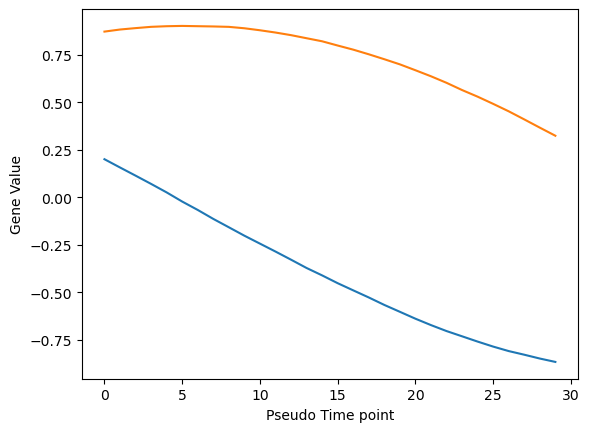

In [ ]:
np.random.seed(42)
    
# Define system parameters
n_genes = 2
n_cells = 50
n_timepoints = 30
epsilon = 0.01
dt = 0.1

# Create true system matrix A and constant load vector b
#A_true = -0.1*np.eye(n_genes)
A_true = np.array([[0,-0.5],[0.5,0]])
eig_val,_ = np.linalg.eig(A_true)
print("Eigenvalues of A are: ",eig_val)
b_true = 0*np.ones(n_genes)

# Initial distribution mean
x0 = np.random.random(n_genes)

# Generate synthetic data
scdata,Tgrid = generate_discrete_time_system_data(
    A_true, b_true, x0, n_timepoints, dt, n_cells, epsilon
)

plt.plot(np.mean(scdata,2))
plt.xlabel("Pseudo Time point")
plt.ylabel("Gene Value");


In [4]:
A_true

array([[ 0. , -0.5],
       [ 0.5,  0. ]])

### GRIT CODE

#### Main GRIT

In [ ]:
## Inputs
## Now we assuming all data comes from the same branch 
#TFflag = []

def GRIT(scdata,Tgrid):
    """
    Python implementation of GRITmodelSelect function for gene regulatory network inference

    Parameters:
    -----------
    scdata : list of numpy arrays
        Single-cell data for each time point
    Tgrid : list or numpy array
        Time points for the data
    opts : dict, optional
        Options for the algorithm
    Returns:
    --------
    Gene regulatory matrix A and the transport maps
    size of A is (n_genes, n_genes + 1)
    """


    disp = 'basic'
    epsilon = 0.01
    iterations = 30
    zeroWeight = 1
    Nred = min(100, scdata[0].shape[0])

    # Get dimensions
    ndim = scdata[0].shape[0]  # Number of genes
    nbr = 1

    # Count cells in samples
    ncell = np.zeros(len(scdata), dtype=int)
    nzeros = 0
    nelements = 0

    # Process each time point
    for jt in range(len(scdata)):
        ncell[jt] = scdata[jt].shape[1]
        nzeros += np.sum(scdata[jt] == 0)
        nelements += scdata[jt].size

    # Process time grid for Single experiment
    Tgrid = np.array(Tgrid)
    indtr = np.arange(len(scdata)-1)
    indw = np.arange(sum(ncell[:-1]))
    Ttot = max(Tgrid) - min(Tgrid)

    # Check consistency
    if len(Tgrid) != len(scdata):
        raise ValueError("Time grid vector length does not match the data structure size")

    # at each time point, calculate variance for each gene over all cells
    vvs = np.zeros((ndim, len(indtr)))
    for jt in range(len(indtr)):
        mtemp = np.mean(scdata[indtr[jt]+1], axis=1, keepdims=True) 
        mtemp[np.isnan(mtemp)] = 0
        vvs[:, jt] += np.sum((scdata[indtr[jt]+1]- mtemp)**2, axis=1)
        vvs[:, jt] = vvs[:, jt] / ncell[indtr[jt]+1] 

    # weight the vvs by number of cells in the previous time step 
    weighted_vvs = np.zeros_like(vvs)
    for jt in range(len(indtr)):
        weighted_vvs[:, jt] = ncell[indtr[jt]] * vvs[:, jt]

    # final variance is 
    vvs = 0.5 + 0.2 * np.sum(weighted_vvs, axis=1, keepdims=True) / np.sum(ncell[indtr]) + 0.8 * vvs
    vvs = vvs**(-0.5)

    # Build regression matrices
    XX = np.empty((ndim + nbr, 0))
    #XX = np.empty((ndim, 0)) #change 1
    DT = np.empty(0)

    for jt in range(len(indtr)):
        branch_padding = np.ones((1, ncell[indtr[jt]])) 
        data_with_branch = np.vstack([scdata[indtr[jt]],branch_padding]) #change 2
        XX = np.hstack([XX, data_with_branch])
        #data_at_jt = scdata[indtr[jt]]
        #XX = np.hstack([XX, data_at_jt])

        dt_values = (Tgrid[indtr[jt]+1] - Tgrid[indtr[jt]])**0.5 * np.ones(ncell[indtr[jt]])
        DT = np.hstack([DT, dt_values])

    YY = np.zeros((ndim, XX.shape[1]))

    # Regularization weights
    D = 0.01 * Ttot * np.diag(XX @ XX.T) / XX.shape[1]
    D[-nbr:] = 10 * D[-nbr:] #change 3

    #  Weight matrix for each cell, set to 1
    WW = np.ones((ndim, sum(ncell)))

    # Calculate correlations and dimension reduction
    # Xc = XX[:ndim, :]
    # indmiss = np.setdiff1d(np.arange(len(scdata)), indtr)
    

    # for im in indmiss:
    #     Xc = np.hstack([Xc, scdata[im]])

    # Xc = Xc - np.mean(Xc, axis=1, keepdims=True)


    # nred = min(Nred, min(Xc.shape))

    # perform SVD
    # U, S, _ = np.linalg.svd(Xc, full_matrices=False)
    # Ured = U[:, :nred]
    # print(np.shape(Ured))
    # S = S[:nred]
    # indmiss = np.hstack([[0], indmiss])

    # Scale XX by time differences
    XX = DT * XX

    A = np.zeros((ndim, ndim+nbr)) # change 4
    #A = np.ones((ndim, ndim))
    difs = np.zeros(iterations)
    J = np.zeros(iterations)

    uFin = [1] * len(indtr)
    transportMap = [None] * len(scdata)

    # Prepare for main iteration loop
    convergenceProblemIndicator = [0] * len(indtr)
    tMap = [None] * len(indtr)
    Jadd = [0] * len(indtr)
    its = [0] * len(indtr)
    der = [None] * len(indtr)

    # Main iterative loop
    for jiter in range(iterations):
        kreg = min(0.5 + 0.7 * (jiter+1) / iterations, 1)
        Aold = A.copy()

        # Process each transition
        for jt in range(len(indtr)):
            # Propagated and target points
            # change 5
            branch_padding = np.ones((1, ncell[indtr[jt]])) 
            X0 = scdata[indtr[jt]] + (Tgrid[indtr[jt]+1] - Tgrid[indtr[jt]]) * A @ np.vstack([scdata[indtr[jt]], branch_padding])
            #X0 = scdata[indtr[jt]] + (Tgrid[indtr[jt]+1] - Tgrid[indtr[jt]]) * A @ scdata[indtr[jt]]
            X1 = scdata[indtr[jt]+1]

            # Cost matrix
            ett0 = np.ones((X0.shape[1], 1))
            ett1 = np.ones((X1.shape[1], 1))


            vX0 = vvs[:, jt].reshape(-1, 1) * X0
            vX1 = vvs[:, jt].reshape(-1, 1) * X1

            # ignore svd
            #UvX0 = Ured.T @ vX0
            #UvX1 = Ured.T @ vX1

            # ignore svd
            UvX0 = vX0
            UvX1 = vX1

            sum_UvX0_squared = np.sum(UvX0**2, axis=0).reshape(-1, 1)
            sum_UvX1_squared = np.sum(UvX1**2, axis=0)


            C = sum_UvX0_squared @ ett1.T - 2 * UvX0.T @ UvX1 + ett0 @ sum_UvX1_squared.reshape(1, -1)

            # only for same amount of cell in each time point
            mu0 = np.ones(np.shape(X0)[1])/np.shape(X0)[1]
            mu1 = np.ones(np.shape(X1)[1])/np.shape(X1)[1]

            if jiter == 0:
                uInit = mu1
            else:
                uInit = uFin[jt]

            # Solve optimal transport problem
            epsloc = epsilon
            failInd = True
            failedSinkhornIterations = -1

            M = None
            uFinal = None
            transport_cost = 0
            reg_cost = 0
            iteration_count = 0

            while failInd and failedSinkhornIterations < 10:
                transport_cost, reg_cost, M, iteration_count, uFinal =  OTsolver_MATLABCODE(mu0, mu1, C, epsloc * np.median(C), uInit)
                #transport_plan = ot.sinkhorn(a, b, cost_matrix, epsilon, method=method)

                failInd = np.sum(np.isnan(M)) > 0
                epsloc = 1.5 * epsloc
                failedSinkhornIterations += 1

            if jiter == iterations - 1 and failedSinkhornIterations > 0:
                convergenceProblemIndicator[jt] = 1

            tMap[jt] = M
            uFin[jt] = uFinal
            Jadd[jt] = transport_cost + epsilon * np.median(C) * reg_cost
            its[jt] = iteration_count

            M = M / np.sum(M, axis=1, keepdims=True)

            # Estimate derivatives
            ww_slice = WW[:, sum(ncell[:indtr[jt]]):sum(ncell[:indtr[jt]+1])]

            M_product = ww_slice @ M
            X1M = X1 @ M.T

            der[jt] = ((X1M / M_product) - scdata[indtr[jt]]) / (Tgrid[indtr[jt]+1] - Tgrid[indtr[jt]])**0.5

        # Collect derivatives
        iaux = 0
        for jt in range(len(indtr)):
            YY[:, iaux:iaux + der[jt].shape[1]] = der[jt] # construct derivative
            J[jiter] += Jadd[jt]
            iaux += der[jt].shape[1]
            transportMap[indtr[jt]] = tMap[jt]

        # Solve for A using regression
        Anew = np.zeros_like(A)

        for jg in range(ndim):

            WV = np.zeros(YY.shape[1])
            iaux = 0
            for jt in range(len(indtr)):
                WV[iaux:iaux + ncell[indtr[jt]]] = vvs[jg, jt]**2
                iaux += ncell[indtr[jt]]

            # Weight matrices
            W_diag = WV * WW[jg, indw]
            #XX_TF = XX[TFloc, :]

            # Weighted regression with regularization
            #weighted_XX = XX_TF * W_diag
            weighted_XX = XX * W_diag
            weighted_YY = YY[jg, :] * W_diag

            #reg_matrix = weighted_XX @ XX_TF.T + np.diag(D[TFloc])
            reg_matrix = weighted_XX @ XX.T + np.diag(D)
            #Anew[jg, TFloc] = weighted_YY @ XX_TF.T @ np.linalg.inv(reg_matrix)
            Anew[jg, :] = weighted_YY @ XX.T @ np.linalg.inv(reg_matrix)



        # Regularized update
        A = (1 - kreg) * Aold + kreg * Anew

        # Check progress
        difs[jiter] = np.sqrt(np.sum((A - Aold)**2))

        if disp == 'all':
            print(f"Iteration {jiter+1}/{iterations} done.")

    # Final A is the unregularized one
    A = Anew

    # Check for and report about convergence problems
    # expnr = 0
    # for jt in range(len(convergenceProblemIndicator)):
    #     if convergenceProblemIndicator[jt] == 1:
    #         if expnr == 0:
    #             warnings.warn("Convergence problems detected and regularisation increased")
    #             print("Check the following matrices for outliers:")

    #         expnr = 1 + indtr[jt] - jt
    #         tpnr = indtr[jt] - indmiss[expnr]
    #         print(f"* Experiment {expnr}, time points {tpnr} and {tpnr+1}")


    if disp != 'off':
         print("Model identification complete.")

    #OUTPUT = [XX, YY, transportMap, J, A, D, WW, corNet, indw, indexp, TFflag, difs, out, opts]
    return  A[:,:-1]

In [58]:
A = GRIT(scdata,Tgrid)
print(A)

Model identification complete.
[[-2.29671793e-02 -5.03239377e-01 -3.11967252e-04]
 [ 5.01582638e-01 -1.19189310e-02  1.07557062e-02]]


In [20]:
GRIT(scdata,Tgrid)

Model identification complete.


array([[-2.29671793e-02, -5.03239377e-01, -3.11967252e-04],
       [ 5.01582638e-01, -1.19189310e-02,  1.07557062e-02]])

### Save predicted A to h5 file